# Simplified model for UHECR data

Here we use a simplified version of the model described in *Soiaporn, K. et al., 2012. Multilevel Bayesian framework for modeling the production, propagation and detection of ultra-high energy cosmic rays. arXiv.org, astro-ph.HE(3), pp.1249–1285* and summarised in soiaporn_model.ipynb to generate simulated data for the UHECR arrival directions.


A generative model is built here to simulate datasets and test the fit for known parameters. 

In [4]:
%matplotlib inline
import sys
sys.path.append('../')
from matplotlib import pyplot as plt
import numpy as np
from fancy import *

In [5]:
# read in relevant data
source_file = 'data/agn_catalog.dat'

# define a Data() instance to handle all data
data = Data()

# add the AGN data
data.add_source(source_file, 'AGN')

## Sources

For the most basic model start with just the sources and no dtection effects. The source distribution is defined by the luminosity function $(F_T, f)$ and the hyperparameters $s$, $a$ and $b$:

<div><center>
$ g(F_T) = \frac{1}{s}e^{-F_T/s}$
<center></div>
<div><center>
$ h(f) = \frac{1}{B(a,b)}f^{a-1}(1-f)^{b-1}$
<center></div>

With s = $0.01 \times 4\pi$, and a = b = 1.
We have the *luminosity function* of a standard candle: $F_k = I/D_k^2$, but we choose instead to represent I through the total source flux: $ F_A = \sum_{k=1}^{N_A} $. So, $F_k = w_kF_A$ with the weights $w_k = \frac{1/D_k^2}{\sum_{j=1}^{N_A} 1/D_j^2}$. 

For now we set the total integrated flux to 500 events, to be distributed amongst the sources depending on their distance from Earth.

The associated fraction is 1 for now, for simplicity. So, all events are associated with the 17 AGN in the sample.

We have:

* $F_T = 500$
* $f = 1$

In [6]:
# set source parameters
F_T = 1000 # total flux
f = 1 # associated fraction
F_A = f * F_T # source flux

In [7]:
# use this model to generate simulated data from the given AGN sources
# distances to AGN
D = data.source['AGN'].distance

# number of AGN
N_A = len(D) 

# function to calculate the weights
def get_weights(D):
    normalisation = 0
    for D_j in D:
        normalisation += (1 / D_j**2)  
    
    w = []
    for D_k in D:
        w.append( (1 / D_k**2) / normalisation)
    w = np.asarray(w)
    return w

# how many events to simulate for each source?
w = get_weights(D)
F = []
for w_k in w:
    F.append(int(round(w_k * F_T)))
print ('Total flux:', sum(F))

Total flux: 1001


## Propagation

Due to magnetic fields, the UHECR trajectories are deflected. For a simple model, this deflection can de described by a von Mises - Firsher distribution:

<div><center>
$\rho_k(\omega | \kappa) = \frac{\kappa}{4\pi sinh(\kappa)}e^{\kappa \omega . \varpi_k}$    
<center></div>

Where:

* $\kappa$ is the concentration parameter
* $\omega$ is the UHECR direction
* $\varpi_k$ is the source direction

Here, we set the concentration parameter to be $\kappa = 100$

In [8]:
# set the propagation parameter
kappa = 2

In [20]:
from vMF import *
from astropy.coordinates import SkyCoord
from astropy import units as u

# Now try with the vMF distribution 
# get the positions of the sources
skycoords = data.source['AGN'].coord

# convert to cartesian coordinates
varpi = [skycoords.cartesian.x, skycoords.cartesian.y, skycoords.cartesian.z] 
varpi = np.transpose(varpi)

# Make a wapper class to store output
class Direction():
    """
    Input the unit vector vMF samples and 
    store x, y, and z and galactic coordinates 
    of direction in Mpc.
    
    :param omega_k: unit vector
    :param norm: unit vector = vector / norm
    """
    
    def __init__(self, omega_k, norm):
        self.unit_vector = omega_k 
        self.norm = norm
        self.x = np.transpose(omega_k)[0] * self.norm
        self.y = np.transpose(omega_k)[1] * self.norm
        self.z = np.transpose(omega_k)[2] * self.norm
        self.d = SkyCoord(self.x, self.y, self.z, 
                          unit = 'mpc', 
                          representation_type = 'cartesian', 
                          frame = 'galactic')
        self.d.representation_type = 'spherical'
        self.lons = self.d.galactic.l.wrap_at(360 * u.deg).deg
        self.lats = self.d.galactic.b.wrap_at(180 * u.deg).deg
        
# simulate events
omega = []
mus = []
for i in range(N_A):
    N = F[i]
    # normalise to unit sphere for sampling, then revert
    norm = np.linalg.norm(varpi[i])
    mu = varpi[i] / norm
    mus.append(Direction(mu, norm))
    omega_k = (sample_vMF(mu, kappa, N))
    omega.append(Direction(omega_k, norm))

In [22]:
print (mus[0].unit_vector)
print (omega[0].unit_vector[0])

[ 0.00766903 -0.87878365 -0.47715876]
[ 0.83778808 -0.54318455  0.05533249]


/Users/fran/projects/bayes/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


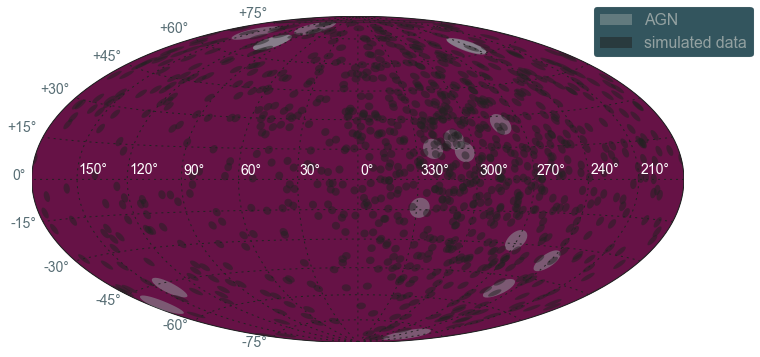

In [10]:
# plot the results on a skymap
fig, skymap = data.show()
label = True
for o in omega:
    for lon, lat in np.nditer([o.lons, o.lats]):
        if label:
            skymap.tissot(lon, lat, 2, npts = 30, facecolor = 'k', alpha = 0.5, 
                          label = 'simulated data')
            label = False
        else:
            skymap.tissot(lon, lat, 2, npts = 30, facecolor = 'k', alpha = 0.5)

plt.gca()
plt.legend(bbox_to_anchor=(0.85, 0.85))

## Detection effects

The arrival direction of UHECR is reconstructed with a certain uncertainty by the PAO team. This is quantified here by the von Mises-Fisher distribution for the data:

<div><center>
$P(d_i | \omega_i) = \frac{\kappa}{4\pi sinh(\kappa)}e^{\kappa d_i \omega_i}$    
<center></div>

We can sample from this distibrution, assuming the true arrival direction is a certain source. For now we leave out the detection effects for simplicity.

## Fitting the model in Stan

The Stan model is written up in `simplified_model.stan`. For the fit, we don't need to have the UHECR directions in galactic coordinates. 


In [37]:
# data reduction
# flatten all the source locations and simulated data into vectors of unit vectors
omega_flat = [] 
varpi_flat = []
for n in range(N_A):
    for o in omega[n].unit_vector:
        omega_flat.append(o)
for mu in mus:
    varpi_flat.append(mu.unit_vector) 

(17, 3)


In [38]:
# set up the data
# for now, input omega and varpi as 3D unit vectors
# for now, try with only one source and only one UHECR
data_for_stan = {'N_A' : 17,
        'N' : 1001,
        'varpi' : varpi_flat,
        'omega' : omega_flat,
        'w' :  w}

In [35]:
# compile the model
import pystan
sm = pystan.StanModel(file = 'simplified_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d50d3861bdb95f23044faa46f3153de7 NOW.


In [39]:
fit = sm.sampling(data = data_for_stan, iter = 1000, chains = 4)

/Users/fran/projects/bayes/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [40]:
print (fit)

Inference for Stan model: anon_model_d50d3861bdb95f23044faa46f3153de7.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
F_T     1032.3   15.83 465.45 178.58 713.02 1023.1 1357.2 1982.7    864    1.0
kappa     2.08  5.2e-3   0.15   1.81   1.98   2.08   2.18   2.38    779   1.01
F_A[0]   19.15    0.29   8.63   3.31  13.23  18.98  25.17  36.78    864    1.0
F_A[1]   17.89    0.27   8.07    3.1  12.36  17.73  23.52  34.37    864    1.0
F_A[2]   26.61    0.41   12.0    4.6  18.38  26.38  34.99  51.11    864    1.0
F_A[3]   21.45    0.33   9.67   3.71  14.82  21.26   28.2   41.2    864    1.0
F_A[4]   30.44    0.47  13.73   5.27  21.03  30.17  40.02  58.47    864    1.0
F_A[5]   25.77     0.4  11.62   4.46   17.8  25.54  33.88  49.49    864    1.0
F_A[6]   92.43    1.42  41.67  15.99  63.84   91.6 121.51 177.52    864    1.0
F_A[7]   40.26    0.62 

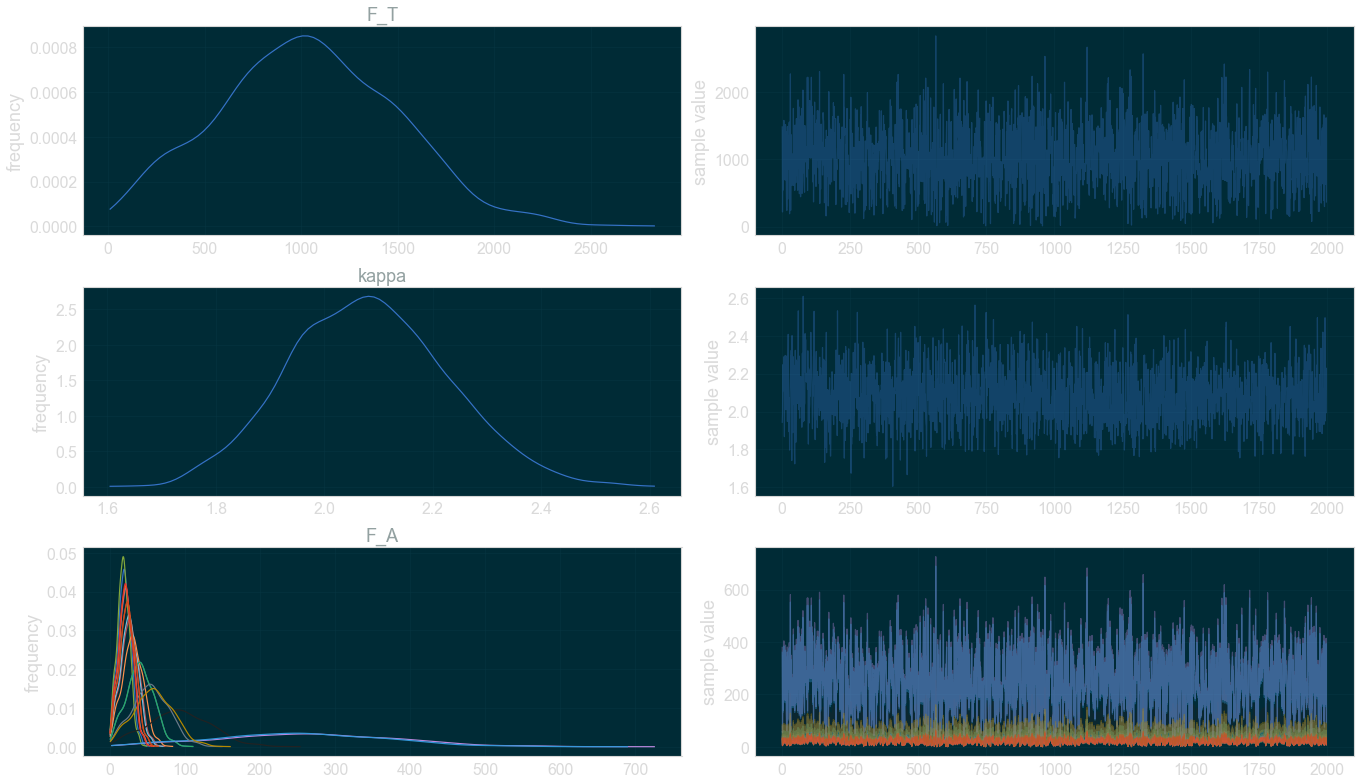

In [41]:
fig = fit.plot();
fig.set_size_inches(19, 11)
fig.tight_layout()

In [42]:
print(F[12])

244
